# Create Components

In [1]:
from __future__ import division, print_function, absolute_import
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import cv2
import os
import sys
from PIL import Image
from timeit import time

# set config to initialize cudnn
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

from stereo_reconstruction import structure
from stereo_reconstruction import processor
from stereo_reconstruction.features import match_images

from yolo3_deepsort.yolo import YOLO
from yolo3_deepsort.deep_sort.detection import Detection
from yolo3_deepsort.deep_sort.tracker import Tracker
from yolo3_deepsort.tools import generate_detections as gdet
from yolo3_deepsort.tools.plot_utils import draw_one_box as draw_box
from yolo3_deepsort.deep_sort.detection import Detection as ddet
import yolo3_deepsort.tools.box_filter as box_filter

Using TensorFlow backend.


In [2]:
# create yolov3 detector
score_thre = 0.5
iou_thre = 0.3
# yolo = YOLO(model_path = 'yolo3_deepsort/model_data/yolo_ori.h5',
#             classes_path = 'yolo3_deepsort/model_data/coco_classes.txt',
#             weights_only = True,
#             score = score_thre,
#             iou = iou_thre) # coco version
yolo = YOLO(model_path = 'yolo3_deepsort/model_data/trained_weights_coco.h5',
            classes_path = 'yolo3_deepsort/model_data/classes_name.txt',
            weights_only = True,
            score = score_thre,
            iou = iou_thre) # our version

# create feature encoder
model_filename = 'yolo3_deepsort/model_data/mars-small128.pb'
encoder = gdet.create_box_encoder(model_filename,batch_size=1)

# create tracker
max_distance = 0.3
lambda0 = 1# SORT
nn_budget = None
tracker = Tracker(metric_mode="cosine",max_cosine_distance=max_distance,
                      lambda0 = lambda0,nn_budget=nn_budget)

yolo3_deepsort/model_data/trained_weights_coco.h5 model, anchors, and classes loaded.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where






# Detection Tracking and Matching

In [3]:
import time
# video_path = r"G:\binocular_video\20191022_022500_video.h265"
video_path = "/media/yxhuang/database/binocular_video/20191022_022500_video.h265"
cap = cv2.VideoCapture(video_path)
w = int(cap.get(3))
h = int(cap.get(4))
fps = cap.get(5)
thickness = 150
COI = ['person','bicycle','car','motorcycle','bus','train','truck']

write_flag = False
if write_flag:
    out = cv2.VideoWriter('result/road_test_COCO2.avi',cv2.VideoWriter_fourcc(*'XVID'), fps, (w//2,2*h))
fontsize = 25

In [ ]:
while cap.isOpened():
    toi = time.time()
    # read video
    ret,frame = cap.read()
    
    if ret != True:
        break# it's really really really important!!!
        
    frame_left = frame[:,:w//2,:]
    frame_right = frame[:,w//2:,:]
    img_left_pil = Image.fromarray(frame_left.copy()[...,::-1])
    img_right_pil = Image.fromarray(frame_right.copy()[...,::-1])
    
    # detection
    boxes,classes,scores = yolo.detect_image(img_left_pil)
    
    # filter boxes
    boxes, classes, scores = box_filter.remove_edge(boxes,classes,scores,thickness,(w//2,h))
    boxes, classes, scores = box_filter.select_classes(boxes,classes,scores,COI)
    boxes, classes, scores = box_filter.non_max_suppression(boxes,classes,scores,iou_thre)

    # encoder features
    features = encoder(frame_left,boxes)
    detections = [Detection(bbox,score,class_,feature)
                    for bbox,score,class_,feature in zip(boxes,scores,classes,features)]
#     detections = [Detection(bbox, score, class_)
#                 for bbox,score,class_ in zip(boxes,scores,classes)]
    
    # call the tracker
    tracker.predict()
    tracker.update(detections)
    
#     print("fps:%f"%(1/(time.time()-toi)))
    
    # Visualize result++++++++++++++++++
    img_left_draw = img_left_pil.copy()
    img_right_draw = img_right_pil.copy()
    for i,track in enumerate(tracker.tracks):
        if not track.is_confirmed() or track.time_since_update > 1:
            continue
        
        # track.to_tlbr() actually get ltrb && track.to_tlwh() actually get ltwh 
        bbox = track.to_tlbr()
        _,_,bbox_matched = match_images(frame_left,frame_right,track.to_tlwh().astype(int),
                                        offset=(-400,-40,0,40),method = cv2.TM_CCOEFF_NORMED)# match two image
        
        # property of the object
        object_id = track.track_id
        object_class = track.object_class
        color = yolo.colors[yolo.class_names.index(object_class)]
        # draw boxes
        img_left_draw = draw_box(img_left_draw,bbox,object_id,object_class,color,fontsize)
        img_right_draw = draw_box(img_right_draw,bbox_matched,object_id,object_class,color,fontsize)
    
#     print("fps:%f"%(1/(time.time()-toi)))
    
    img_left_show = np.asarray(img_left_draw)
    img_right_show = np.asarray(img_right_draw)
    img_show = np.concatenate((img_left_show,img_right_show),axis = 0)
    
    if write_flag:
        out.write(img_show[...,::-1])# save result
    cv2.imshow('demo',cv2.resize(img_show[...,::-1],(int(w/2.5),int(h/1.5))))
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
if write_flag:
    out.release()
cap.release()
cv2.destroyAllWindows()

# 3D reconstruct

In [31]:
# Read Parameters

work_path = "/media/yxhuang/database/binocular_video/"
intrinsic_path = work_path + r'stereo_intrinsic.yml'
extrinsic_path = work_path + r'stereo_extrinsic.yml'
# intrinsic_path = r'G:\binocular_video\stereo_intrinsic.yml'
# extrinsic_path = r'G:\binocular_video\stereo_extrinsic.yml'
intrinsic_paras = cv2.FileStorage(intrinsic_path, cv2.FILE_STORAGE_READ)
extrinsic_paras = cv2.FileStorage(extrinsic_path, cv2.FILE_STORAGE_READ)
P1 = extrinsic_paras.getNode('P1').mat()
P2 = extrinsic_paras.getNode('P2').mat()
R1 = extrinsic_paras.getNode('R1').mat()
R2 = extrinsic_paras.getNode('R2').mat()
T1 = np.zeros((3,1))
T2 = extrinsic_paras.getNode('T').mat()
M1 = intrinsic_paras.getNode('M1').mat()
M2 = intrinsic_paras.getNode('M2').mat()
D1 = intrinsic_paras.getNode('D1').mat()
D2 = intrinsic_paras.getNode('D2').mat()
# print(P1)
# print(np.dot(M1,np.hstack((R1,T1))))
# print(P2)
# print(np.dot(M2,np.hstack((R2,T2))))

In [32]:
# Read Images

img_left = cv2.imread(work_path+'img/3400_left.jpg')
img_right = cv2.imread(work_path+'img/3400_right.jpg')

img_left_pil = Image.fromarray(img_left.copy()[...,::-1])
img_right_pil = Image.fromarray(img_right.copy()[...,::-1])

In [33]:
# Detection and Matching

COI = ['person','bicycle','car','motorcycle','bus','train','truck']
h_img,w_img,_ = img_left.shape
thickness = 150
boxes,classes,scores = yolo.detect_image(img_left_pil)# detect object

# filter boxes
boxes, classes, scores = box_filter.remove_edge(boxes,classes,scores,thickness,(w_img,h_img))
boxes, classes, scores = box_filter.select_classes(boxes,classes,scores,COI)
boxes, classes, scores = box_filter.non_max_suppression(boxes,classes,scores,iou_thre)

# NMS
# idx2 = box_filter.non_max_suppression_idx(boxes,0.5,scores)
# boxes, classes, scores = box_filter.get_by_index(idx2,boxes, classes, scores)

boxes_matched = []
boxes = np.array(boxes)# easier to compute
img_left_draw = img_left_pil.copy()
img_right_draw = img_right_pil.copy()
for i,box in enumerate(boxes):
    ret,search_patch,box_matched = match_images(img_left,img_right,box,offset=(-400,-40,0,40),
                                   method = cv2.TM_CCOEFF_NORMED)# match two image
    boxes_matched.append(box_matched)
#     search_patches.append(search_patch)
#     rets.append(ret)
    
    object_id = '0'
    object_class = classes[i]
    color = yolo.colors[yolo.class_names.index(object_class)]
    # draw boxes
    box[2:] = box[2:] + box[:2]# ltwh 2 ltrb. Note boxes had been changed!!!!!
    img_left_draw = draw_box(img_left_draw,box,object_id,object_class,color,20)
    img_right_draw = draw_box(img_right_draw,box_matched,object_id,object_class,color,20)
#     print("box_r",box_matched)
    
boxes_matched = np.array(boxes_matched)

img_left_show = np.asarray(img_left_draw)
img_right_show = np.asarray(img_right_draw)
plt.figure(figsize=(16,10))
plt.subplot(121)
plt.imshow(img_left_show)
plt.subplot(122)
plt.imshow(img_right_show)

cv2.imshow('left',img_left_show[...,::-1])
cv2.imshow('right',img_right_show[...,::-1])
cv2.waitKey(0)
cv2.destroyAllWindows()

UnknownError: 2 root error(s) found.
  (0) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node conv2d_1/convolution (defined at /home/yxhuang/anaconda3/envs/tf14/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3650) ]]
	 [[boolean_mask_4/GatherV2/_2859]]
  (1) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node conv2d_1/convolution (defined at /home/yxhuang/anaconda3/envs/tf14/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3650) ]]
0 successful operations.
0 derived errors ignored.

Errors may have originated from an input operation.
Input Source operations connected to node conv2d_1/convolution:
 input_1 (defined at /home/yxhuang/anaconda3/envs/tf14/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517)	
 conv2d_1/kernel/read (defined at /home/yxhuang/anaconda3/envs/tf14/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:402)

Input Source operations connected to node conv2d_1/convolution:
 input_1 (defined at /home/yxhuang/anaconda3/envs/tf14/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517)	
 conv2d_1/kernel/read (defined at /home/yxhuang/anaconda3/envs/tf14/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:402)

Original stack trace for 'conv2d_1/convolution':
  File "/home/yxhuang/anaconda3/envs/tf14/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/yxhuang/anaconda3/envs/tf14/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/yxhuang/anaconda3/envs/tf14/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/yxhuang/anaconda3/envs/tf14/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/yxhuang/anaconda3/envs/tf14/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/home/yxhuang/anaconda3/envs/tf14/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/yxhuang/anaconda3/envs/tf14/lib/python3.7/asyncio/base_events.py", line 538, in run_forever
    self._run_once()
  File "/home/yxhuang/anaconda3/envs/tf14/lib/python3.7/asyncio/base_events.py", line 1782, in _run_once
    handle._run()
  File "/home/yxhuang/anaconda3/envs/tf14/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/yxhuang/anaconda3/envs/tf14/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/yxhuang/anaconda3/envs/tf14/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/yxhuang/anaconda3/envs/tf14/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/yxhuang/anaconda3/envs/tf14/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/yxhuang/anaconda3/envs/tf14/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 361, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/yxhuang/anaconda3/envs/tf14/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/yxhuang/anaconda3/envs/tf14/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/yxhuang/anaconda3/envs/tf14/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/yxhuang/anaconda3/envs/tf14/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 541, in execute_request
    user_expressions, allow_stdin,
  File "/home/yxhuang/anaconda3/envs/tf14/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/yxhuang/anaconda3/envs/tf14/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 300, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/yxhuang/anaconda3/envs/tf14/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/yxhuang/anaconda3/envs/tf14/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2858, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/yxhuang/anaconda3/envs/tf14/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2886, in _run_cell
    return runner(coro)
  File "/home/yxhuang/anaconda3/envs/tf14/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/yxhuang/anaconda3/envs/tf14/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3063, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/yxhuang/anaconda3/envs/tf14/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3254, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/yxhuang/anaconda3/envs/tf14/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-46612da1d78e>", line 13, in <module>
    iou = iou_thre) # our version
  File "/media/yxhuang/doc/MyWorld/junote/ByicycleBehaviorAnalysis/yolo3_deepsort/yolo.py", line 48, in __init__
    self.boxes, self.scores, self.classes = self.generate()
  File "/media/yxhuang/doc/MyWorld/junote/ByicycleBehaviorAnalysis/yolo3_deepsort/yolo.py", line 73, in generate
    self.yolo_model = yolo_body(image_input,num_anchors,num_classes)
  File "/media/yxhuang/doc/MyWorld/junote/ByicycleBehaviorAnalysis/yolo3_deepsort/yolo3/model.py", line 72, in yolo_body
    darknet = Model(inputs, darknet_body(inputs))
  File "/media/yxhuang/doc/MyWorld/junote/ByicycleBehaviorAnalysis/yolo3_deepsort/yolo3/model.py", line 48, in darknet_body
    x = DarknetConv2D_BN_Leaky(32, (3,3))(x)
  File "/media/yxhuang/doc/MyWorld/junote/ByicycleBehaviorAnalysis/yolo3_deepsort/yolo3/utils.py", line 14, in <lambda>
    return reduce(lambda f, g: lambda *a, **kw: g(f(*a, **kw)), funcs)
  File "/media/yxhuang/doc/MyWorld/junote/ByicycleBehaviorAnalysis/yolo3_deepsort/yolo3/utils.py", line 14, in <lambda>
    return reduce(lambda f, g: lambda *a, **kw: g(f(*a, **kw)), funcs)
  File "/home/yxhuang/anaconda3/envs/tf14/lib/python3.7/site-packages/keras/engine/base_layer.py", line 457, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/yxhuang/anaconda3/envs/tf14/lib/python3.7/site-packages/keras/layers/convolutional.py", line 171, in call
    dilation_rate=self.dilation_rate)
  File "/home/yxhuang/anaconda3/envs/tf14/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py", line 3650, in conv2d
    data_format=tf_data_format)
  File "/home/yxhuang/anaconda3/envs/tf14/lib/python3.7/site-packages/tensorflow/python/ops/nn_ops.py", line 894, in convolution
    name=name)
  File "/home/yxhuang/anaconda3/envs/tf14/lib/python3.7/site-packages/tensorflow/python/ops/nn_ops.py", line 971, in convolution_internal
    name=name)
  File "/home/yxhuang/anaconda3/envs/tf14/lib/python3.7/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 1071, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "/home/yxhuang/anaconda3/envs/tf14/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/home/yxhuang/anaconda3/envs/tf14/lib/python3.7/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/yxhuang/anaconda3/envs/tf14/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 3616, in create_op
    op_def=op_def)
  File "/home/yxhuang/anaconda3/envs/tf14/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


In [ ]:
# use the center of boxes stand for object's location
pts2D_1 = np.ones((3,len(boxes)),dtype='float')
pts2D_2 = np.ones((3,len(boxes)),dtype='float')

# boxes[:,2:] = boxes[:,2:] + boxes[:,:2]# ltwh 2 ltrb
for i in range(len(boxes)):
    pts2D_1[:2,i] = (boxes[i,:2] + boxes[i,2:])/2.
    pts2D_2[:2,i] = (boxes_matched[i,:2] + boxes_matched[i,2:])/2.

# triangulation
pts3D = structure.linear_triangulation(pts2D_1,pts2D_2,P1,P2)
# pts3D = structure.linear_triangulation(pts2D_1,pts2D_2,P2,P1)
# X朝右，Y朝上，Z朝前
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(pts3D[0], pts3D[1], pts3D[2], 'b.')
ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')
ax.view_init(elev=135, azim=90)
plt.show()
# print('2D1:')
# print(pts2D_1)
# print("2D2:")
# print(pts2D_2)
# print(pts3D[:3,:])
print("distance:")
print(np.sqrt(np.sum(pts3D[:3,:]**2,axis=0)))

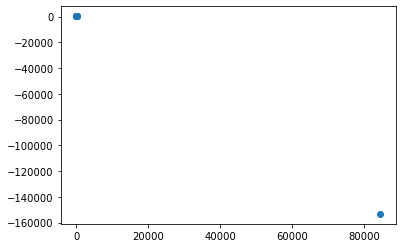

In [30]:
# 俯视图
plt.scatter(pts3D[0,:],pts3D[2,:])